Title

Description

Importing packages.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importing data into pandas DataFrame.

In [42]:
df = pd.read_csv(r"fullDataFinal.csv", index_col=0)
df.columns = df.columns.str.strip()
df.sample(5)

,fire_size_class,latitude,longitude,discovery_month,weekday,Vegetation,remoteness,elevation,Temp,Wind,Humidity,Precipitation
9402,B,34.29002,-80.968781,Jan,True,Broadleaf Forest,0.125243,165.0,2.913529,0.758438,22.334641,0.000000
35119,G,32.61530,-112.109300,Jun,True,Shrubland,0.225579,593.0,33.211757,2.307285,20.116564,0.000000
4965,B,35.30610,-92.087270,Jul,True,Rock,0.225229,195.0,29.991118,2.998553,63.461341,7.500000
4060,B,47.66500,-120.508333,Aug,True,Rock,0.497120,1021.0,20.431591,3.701693,45.886931,2.333333
1986,C,43.63141,-102.564040,Sep,True,Grassland,0.320094,850.0,24.386706,4.860812,48.769894,8.500000


Run this block to get the dataset with the all the features.

In [63]:
# Separate target variable (fire_size_class) from predictor variables.

dfTarget = df["fire_size_class"]
dfPredictor = df[["latitude", "longitude", "discovery_month", "weekday", "Vegetation", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]

# First we one-hot encode all of the classes
dfTarget = pd.concat([dfTarget, pd.get_dummies(dfTarget)], axis=1)  # use get_dummies and concatenate the result to dfTarget
dfTarget.drop(["fire_size_class"], axis=1, inplace=True)  # and remove the old column
# print(dfTarget.sample(5))

# We want to make it binary classification between B and the larger fires
# To do this we can drop all classes other than B
# If B is 0 -> it's larger
dfTarget.drop(["C", "D", "E", "F", "G"], axis=1, inplace=True)
print(dfTarget.sample(5))

# Changing categorical variables into one-hot encoded ones.
# Vegetation
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["Vegetation"], prefix="Veg", prefix_sep=" ")], axis=1)
dfPredictor.drop(["Vegetation"], axis=1, inplace=True)
# And discovery_month
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["discovery_month"])], axis=1)
dfPredictor.drop(["discovery_month"], axis=1, inplace=True)
# And weekday
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["weekday"])], axis=1)
dfPredictor.drop(["weekday"], axis=1, inplace=True)
dfPredictor.rename(columns={False:"is_weekend", True:"is_weekday"}, inplace=True)
dfPredictor.sample(5)


# Scaling numerical data to 0-1 range.
from sklearn.preprocessing import MinMaxScaler

dfPredictorScaled = pd.DataFrame(MinMaxScaler().fit_transform(dfPredictor[["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]), columns=["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"])
# dfPredictorScaled.sample(5)

dfPredictor = dfPredictor.assign(**dfPredictorScaled.to_dict(orient="series"))  # replace the columns of the old df with the ones from the new one
dfPredictor.sample(5)

       B
28865  1
31113  0
23486  1
35851  0
21185  1


,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
6668,0.361151,0.589965,0.359457,0.776193,0.557402,0.150894,0.305397,0.004872,0,0,...,0,0,1,0,0,0,0,0,0,1
21766,0.285001,0.703496,0.253949,0.044432,0.662829,0.061571,0.498025,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,1
26992,0.324109,0.859755,0.111246,0.024685,0.489967,0.122379,0.599048,0.000682,1,0,...,0,0,0,0,0,1,0,0,0,1
33449,0.474498,0.524906,0.049418,0.473121,0.649207,0.090531,0.304629,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,0
20341,0.265804,0.827214,0.142049,0.034833,0.535582,0.073624,0.780265,0.018292,0,0,...,0,0,0,0,0,1,0,0,0,1


Run the block below to get 

Train-test split

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfPredictor, dfTarget, test_size=0.1, random_state=42, stratify=dfTarget)

print(X_train.shape)
print(y_train.shape, "\n")

print(X_test.shape)
print(y_test.shape)

(33522, 28)
(33522, 1) 

(3725, 28)
(3725, 1)


Before SMOTEEN

array([[<AxesSubplot:title={'center':'B'}>]], dtype=object)

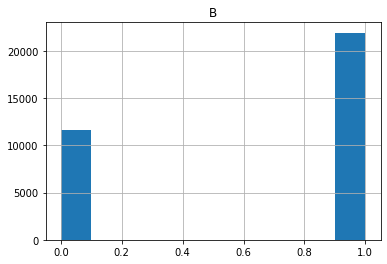

In [67]:
y_train.hist()

In order to fix the distribution of the data when training, we want to change it (in the training set only though).

First, I tried randomly undersampling the data, however that made the training set too small (down to 2.6k samples total). The results were abysmal, with basically every model getting around a 2% accuracy on the test set.

This is the code to do this, in case you want to (but you shouldn't).

In [68]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)

(23236, 28)
(23236, 1)


We want to convert the y_train dataset from a Pandas DataFrame to a (n, ) Numpy array.

In [72]:
y_train = y_train.values.ravel()

Next, I tried the opposite approach -- random *over*sampling.

Here, examples from the smaller classes are picked randomly and repeated in the dataset.

This made the training set massive, at 130k+ samples, but it also made training take forever and didn't achieve great results.

    from imblearn.over_sampling import RandomOverSampler

    ros = RandomOverSampler()
    X_train, y_train = ros.fit_resample(X_train, y_train.values)

    print(X_train.shape)
    print(y_train.shape)

    y_train = pd.DataFrame(y_train)

In [25]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train.to_numpy())
y_train = pd.DataFrame(y_train)

d:\pycharmprojects\thesis\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


After SMOTEEN

array([[<AxesSubplot:title={'center':'B'}>]], dtype=object)

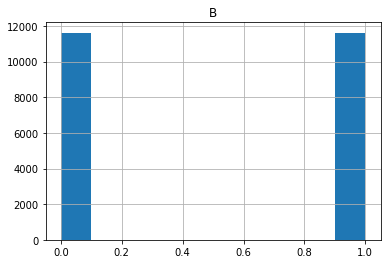

In [69]:
y_train.hist()

Make a correlation matrix

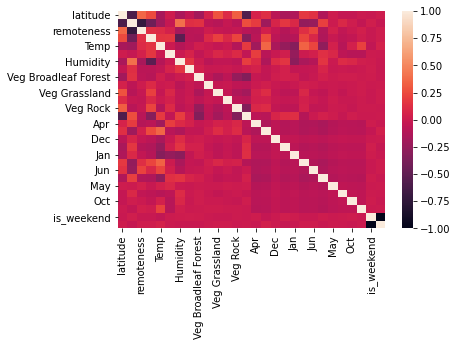

In [37]:
import seaborn as sn

corrMatrix = X_train.corr()
sn.heatmap(corrMatrix)
plt.show()

Training models, each in a cell (?)

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)
* Artificial Neural Network (ANN)

Evaluation with confusion matrix, F1 score, etc

### Dummy classifier

In [73]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()

dummy_clf.fit(X_train, y_train)
training_accuracy = dummy_clf.score(X_train, y_train)
test_accuracy = dummy_clf.score(X_test, y_test)
print(f"Training accuracy: {training_accuracy}")  # 0.6537796074219915
print(f"Test accuracy: {test_accuracy}")  # 0.6502013422818792


y_true, y_pred = y_test , dummy_clf.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Training accuracy: 0.5
Test accuracy: 0.3465771812080537
Results on the test set:
              precision    recall  f1-score   support

           0       0.35      1.00      0.51      1291
           1       0.00      0.00      0.00      2434

    accuracy                           0.35      3725
   macro avg       0.17      0.50      0.26      3725
weighted avg       0.12      0.35      0.18      3725



d:\pycharmprojects\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pycharmprojects\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pycharmprojects\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(2, 30, 2)}

grid_searchKNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
grid_searchKNN.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_searchKNN.score(X_test, y_test)))


y_true, y_pred = y_test , grid_searchKNN.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

print(f"Best test set score: {grid_searchKNN.best_score_} with {grid_searchKNN.best_params_} parameters.")  # 0.6436993848306627 with {'n_neighbors': 25}

Test set score: 0.69
Results on the test set:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1291
           1       0.77      0.76      0.76      2434

    accuracy                           0.69      3725
   macro avg       0.66      0.66      0.66      3725
weighted avg       0.69      0.69      0.69      3725

Best test set score: 0.6436993848306627 with {'n_neighbors': 25} parameters.


25 seems to be the best on our test set. Let's train that model and save it.

In [ ]:
clfKNN = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
clfKNN.fit(X_train, y_train)

training_accuracy = clfKNN.score(X_train, y_train)
test_accuracy = clfKNN.score(X_test, y_test)
print("Number of neighbors: 9")
print(f"\nTraining accuracy: {training_accuracy}")  # 0.7298490543523656
print(f"\nTest accuracy: {test_accuracy}")  # 0.6934228187919463

### Naive Bayes

In [79]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"GaussianNB train score: {gnb.score(X_train, y_train)}")  # 0.21296462024938845
print(f"GaussianNB test score: {gnb.score(X_test, y_test)}")  # 0.21986577181208053
print("\n")

y_true, y_pred = y_test , gnb.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

GaussianNB train score: 0.59330349457738
GaussianNB test score: 0.6429530201342282


Results on the test set:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1291
           1       0.73      0.71      0.72      2434

    accuracy                           0.64      3725
   macro avg       0.61      0.61      0.61      3725
weighted avg       0.65      0.64      0.65      3725



### Support Vector Machine

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}

grid_searchSVC = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_searchSVC.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_searchSVC.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchSVC.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.72
Results on the test set:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55      1291
           1       0.76      0.85      0.80      2434

    accuracy                           0.72      3725
   macro avg       0.69      0.67      0.67      3725
weighted avg       0.71      0.72      0.71      3725



Best seems to be with C = ?

Now lets train the final SVM

In [ ]:
svm = SVC(C = 0.25)
multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
multi_svm.fit(X_train, y_train)

print(f"Kernel SVM train score: {multi_svm.score(X_train, y_train)}")  # 0.7018077680329335
print(f"Kernel SVM test score: {multi_svm.score(X_test, y_test)}")  # 0.6977181208053691
print("\n")

### Decision Tree

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [4, 8, 16, 32, 64, 128, 256, 512], 'criterion': ['gini', 'entropy']}

grid_searchDT = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
grid_searchDT.fit(X_train, y_train)
DT_ResultsDf = pd.DataFrame(grid_searchDT.cv_results_)

print(DT_ResultsDf)
print(f"Best test set score: {grid_searchDT.best_score_} with {grid_searchDT.best_params_} parameters.")

y_true, y_pred = y_test , grid_searchDT.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.090305      0.001199         0.003997    6.468134e-07   
1        0.165829      0.002604         0.003797    3.995420e-04   
2        0.264329      0.003495         0.003797    3.994467e-04   
3        0.297095      0.007779         0.004196    3.993043e-04   
4        0.298693      0.005508         0.004396    4.894732e-04   
5        0.298693      0.009392         0.003797    3.993512e-04   
6        0.306086      0.011207         0.004396    4.890649e-04   
7        0.301690      0.003739         0.004396    4.889282e-04   
8        0.133662      0.003812         0.003997    6.314300e-04   
9        0.239553      0.002558         0.003596    4.897652e-04   
10       0.459329      0.021918         0.003797    3.992081e-04   
11       0.574212      0.033062         0.006593    4.219602e-03   
12       0.556829      0.058337         0.004196    3.994703e-04   
13       0.526460      0.014830         0.004196

Best max_depth is 5 -->  0.72060144

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

print(f"Decision Tree train score: {dt.score(X_train, y_train)}")  # 0.7240618101545254
print(f"Decision Tree test score: {dt.score(X_test, y_test)}")  # 0.7103355704697987
print("\n")

### Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [4, 8, 16, 32, 64, 128, 256, 512], 'n_estimators': [100, 500, 1000], 'criterion': ['gini', 'entropy']}

grid_searchRF = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
grid_searchRF.fit(X_train, y_train)
RF_ResultsDf = pd.DataFrame(grid_searchRF.cv_results_)

print(RF_ResultsDf)
print(f"Best test set score: {grid_searchRF.best_score_} with {grid_searchRF.best_params_} parameters.")


y_true, y_pred = y_test , grid_searchRF.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.310457      0.015876         0.046753        0.000748   
1        6.546496      0.112534         0.214779        0.005650   
2       13.206278      0.236400         0.420769        0.005906   
3        2.390752      0.069540         0.069729        0.012690   
4       11.044292      0.095473         0.294099        0.001623   
5       22.104567      0.085902         0.596789        0.014304   
6        3.666845      0.051906         0.108689        0.002225   
7       18.456303      0.178604         0.548438        0.009435   
8       38.444237      0.400869         1.139034        0.048136   
9        4.490202      0.040899         0.141656        0.003121   
10      23.264179      0.340181         0.705079        0.009401   
11      45.378338      0.158833         1.436329        0.013660   
12       4.614875      0.045619         0.148049        0.009381   
13      22.653006      0.235129         0.704479

Best seems to be with max_depth=12

In [ ]:
rf = RandomForestClassifier(max_depth=12, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Random Forest train score: {rf.score(X_train, y_train)}")  # 0.7210786945886284
print(f"Random Forest test score: {rf.score(X_test, y_test)}")  # 0.6877852348993289
print("\n")


### Gradient Boosted Trees (GBT)

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':[2,4,8,16,30,40], 'loss':['deviance', 'exponential']}

grid_searchGBT = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)
grid_searchGBT.fit(X_train, y_train)
GBT_ResultsDf = pd.DataFrame(grid_searchGBT.cv_results_)

print(GBT_ResultsDf)
print(f"Best test set score: {grid_searchGBT.best_score_} with {grid_searchGBT.best_params_} parameters.")

y_true, y_pred = y_test , grid_searchGBT.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_loss  \
0        4.328169      0.199383         0.010190        0.000979     deviance   
1        7.887125      0.200798         0.012986        0.000631     deviance   
2       15.895523      0.130179         0.020379        0.001355     deviance   
3       38.067223      0.326768         0.042557        0.001355     deviance   
4       62.989905      2.541507         0.088709        0.008415     deviance   
5       58.718878      0.827659         0.087910        0.005508     deviance   
6        3.943162      0.027810         0.009190        0.000400  exponential   
7        7.664752      0.058801         0.012587        0.000489  exponential   
8       15.488541      0.067889         0.020379        0.000490  exponential   
9       40.177063      0.505294         0.044754        0.001325  exponential   
10      71.472819      3.095950         0.085313        0.012865  exponential   
11      57.193240      8.443

### Multi-Layered Perceptron (MLP)

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(5), (5, 5), (10), (10, 10), (10, 5), (5, 10, 5), (15, 30, 15), (5, 10, 10, 5), (15, 30, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_searchMLP = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5, n_jobs=-1)

grid_searchMLP.fit(X_train, y_train)
MLP_ResultsDf = pd.DataFrame(grid_searchMLP.cv_results_)

print(MLP_ResultsDf)
print(f"Best test set score: {grid_searchMLP.best_score_} with {grid_searchMLP.best_params_} parameters.")

y_true, y_pred = y_test , grid_searchMLP.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       19.404132      2.160922         0.004995    1.168008e-07   
1       21.387702      3.315974         0.005794    7.476146e-04   
2       23.851379      2.584907         0.005794    3.995181e-04   
3       20.937162      1.584407         0.006194    3.997567e-04   
4       18.915832      2.266775         0.006194    3.994944e-04   
5       20.225492      6.483543         0.006193    3.995667e-04   
6       22.543118      2.191165         0.011189    3.999235e-04   
7       19.637493      2.592764         0.007992    3.162980e-07   
8       27.296051      6.570260         0.009990    4.523674e-07   
9       11.371356      1.946801         0.004795    3.996611e-04   
10      16.702698      2.600532         0.005594    4.886559e-04   
11      15.373859      2.569150         0.004995    3.162980e-07   
12      16.125688      3.182139         0.006393    4.892591e-04   
13      15.451779      1.229246         0.005994